# ART - Adversarial Patch - PyTorch - YOLO

In [6]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Step 0: Define the neural network model, return logits instead of activation in forward method


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)

from art.attacks.evasion import CarliniL2Method
#attack = CarliniL2Method(classifier=classifier, confidence=0.0, targeted=False,
#                     learning_rate=0.01, binary_search_steps=10, max_iter=10, initial_const=0.01, 
#                     max_halving=5, max_doubling=5, batch_size=1, verbose=True)
#attack = CarliniL2Method(classifier=classifier, confidence=0.0, targeted=False,
#                     learning_rate=0.02, binary_search_steps=5, max_iter=5, initial_const=0.01, 
#                     max_halving=5, max_doubling=5, batch_size=100, verbose=True)

x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))


Accuracy on benign test examples: 97.59%
Accuracy on adversarial test examples: 27.839999999999996%


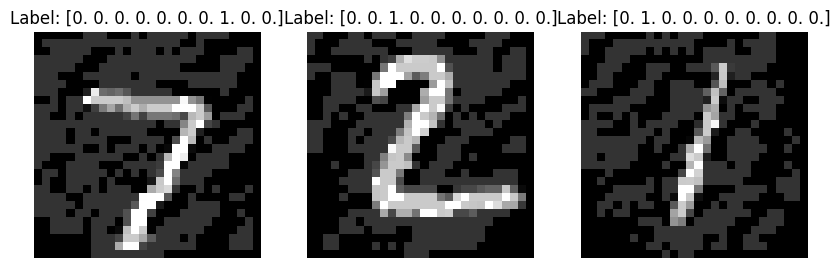

In [7]:
import matplotlib.pyplot as plt

# Display some images
num_images_to_display = 3  # Choose how many images to display

plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)  # Create a grid of subplots
    plt.imshow(np.squeeze(x_test_adv[i]), cmap='gray')  # Display the image in grayscale
    plt.title(f"Label: {y_test[i]}") # Show the label of the image
    plt.axis("off")  # Hide axes ticks and labels

plt.show()

# My Stuff:

## Patch Generation with C&W

In [1]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from tqdm import tqdm

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch


import cv2
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    # plt.show()



In [3]:
import yolov5
from yolov5.utils.loss import ComputeLoss

class Yolo(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {'box': 0.05,
                        'obj': 1.0,
                        'cls': 0.5,
                        'anchor_t': 4.0,
                        'cls_pw': 1.0,
                        'obj_pw': 1.0,
                        'fl_gamma': 0.0
                        }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            loss_components_dict['loss_box'] = loss_items[0]
            loss_components_dict['loss_obj'] = loss_items[1]
            loss_components_dict['loss_cls'] = loss_items[2]
            return loss_components_dict
        else:
            return self.model(x)

model = yolov5.load('yolov5s.pt')

model = Yolo(model)

detector = PyTorchYolo(model=model,
                    device_type='gpu',
                    input_shape=(3, 640, 640),
                    clip_values=(0, 255), 
                    attack_losses=("loss_total", "loss_cls",
                                    "loss_box",
                                    "loss_obj"))

YOLOv5  2024-10-22 Python-3.12.2 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti with Max-Q Design, 6144MiB)

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs
Adding AutoShape... 


In [4]:
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 640, 640)

transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(INPUT_SHAPE[1]),
        transforms.ToTensor()
    ])

urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg',
'http://farm1.staticflickr.com/143/327565091_086d7162de_z.jpg']
coco_images = []
for url in urls:
    im = Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)

coco_images = np.array(coco_images)*255

In [5]:
rotation_max=0.0
scale_min=0.5
scale_max=0.5
distortion_scale_max=0.0
learning_rate=2 #1.99
max_iter=1000 #1000 
batch_size=16
patch_shape=(3, 300, 300)#(3, 200, 200)
patch_location=None
patch_type="square"
optimizer="pgd" # pgd and Adam

In [6]:
def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])

    dictionary["boxes"] = np.vstack(boxes_list)
    dictionary["scores"] = np.hstack(scores_list)
    dictionary["labels"] = np.hstack(labels_list)

    y = [dictionary]

    return y

dets = detector.predict(coco_images) 

y = [filter_boxes([t], 0.8)[0] for t in dets]

In [7]:
#patch, patch_mask = ap.generate(x=coco_images[:-1], y=[y[-1] for i in range(len(coco_images[:-1]))])
i = 0
for sample in y:
    if 12 in sample["labels"]:
        break
    i+=1
i

6

In [8]:
y[5]

{'boxes': array([[     395.52,      214.54,      515.94,      341.48],
        [     395.93,       213.6,      514.98,      342.05],
        [     395.49,      213.64,      515.83,      342.49],
        [     395.93,      213.22,      514.81,      342.61],
        [     394.94,      213.98,      515.91,      342.38],
        [     395.44,      214.62,      515.87,      341.67],
        [        396,      215.29,      515.87,      341.49],
        [     394.65,         214,      516.31,      342.63],
        [     395.32,      214.79,      515.89,      341.66],
        [     395.88,      215.23,      515.88,      341.89],
        [     394.63,      213.82,       516.4,      342.57],
        [     395.28,      214.79,      516.17,      341.72],
        [     395.96,      215.25,      516.12,      341.65]], dtype=float32),
 'scores': array([    0.81471,     0.94616,     0.81706,     0.94433,     0.93858,     0.94094,     0.93196,     0.93516,     0.93971,     0.93177,      0.9308,     0.9

In [9]:

ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)


from art.attacks.evasion import CarliniL2Method
ap = CarliniL2Method(classifier=detector, confidence=0.0, targeted=True,
                     learning_rate=0.01, binary_search_steps=10, max_iter=10, initial_const=0.01, 
                     max_halving=5, max_doubling=5, batch_size=1, verbose=True)



patch, patch_mask = ap.generate(x=coco_images[:-1], y=[y[5] for i in range(len(coco_images[:-1]))]) # 11 is stop sign used as goal target for training the patch (the dataset must then be classified as that)


plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0).astype(np.uint8))
plt.show()

EstimatorError: CarliniL2Method requires an estimator derived from <class 'art.estimators.estimator.BaseEstimator'> and <class 'art.estimators.classification.classifier.ClassGradientsMixin'>, the provided classifier is an instance of <class 'art.estimators.object_detection.pytorch_yolo.PyTorchYolo'> and is derived from (<class 'art.estimators.object_detection.pytorch_object_detector.PyTorchObjectDetector'>,).

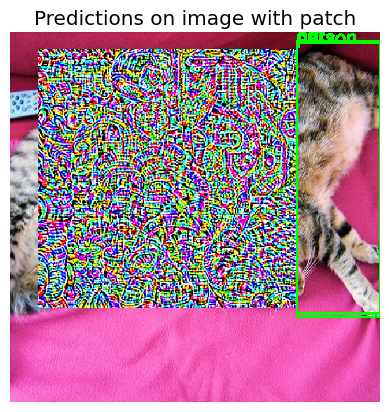

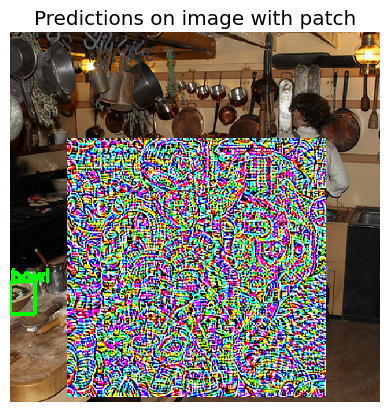

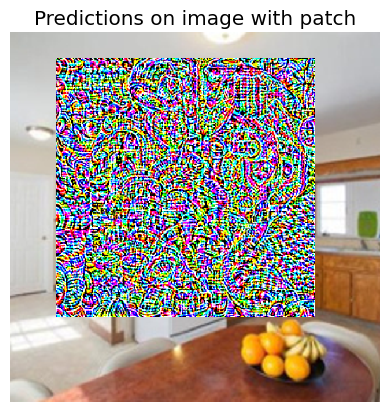

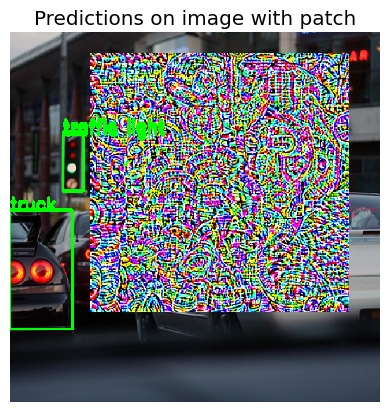

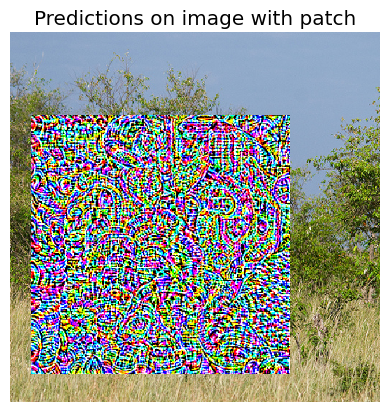

In [ ]:
%matplotlib inline

patched_images = ap.apply_patch(coco_images[:-1], scale=0.7)
dets = detector.predict(patched_images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.5)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")

## C&W

In [ ]:
%matplotlib inline
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_cls.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_box.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_obj.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('Box Loss')
axes[2].set_title('Objectness Loss')
fig.tight_layout()